# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

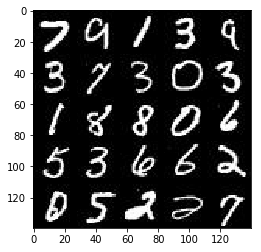

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

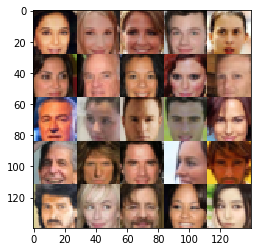

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    image_tensor = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), 
                                  name='input_real')
    z_tensor = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)
    return image_tensor, z_tensor, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(0.15*x1, x1)
        drop1 = tf.nn.dropout(relu1, 0.5)

        x2 = tf.layers.conv2d(drop1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.15 * bn2, bn2)
        drop2 = tf.nn.dropout(relu2, 0.5)

        x3 = tf.layers.conv2d(drop2, 512, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.15 * bn3, bn3)
        drop3 = tf.nn.dropout(relu3, 0.5)
        
        flat = tf.reshape(drop3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*1024)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.15 * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.15 * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.15 * x3, x3)
        
        x31 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same')
        x31 = tf.layers.batch_normalization(x31, training=is_train)
        x31 = tf.maximum(0.15 * x31, x31)

        x4 = tf.layers.conv2d_transpose(x31, 128, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(0.15 * x4, x4)
        
        x41 = tf.layers.conv2d_transpose(x4, 128, 5, strides=1, padding='same')
        x41 = tf.layers.batch_normalization(x41, training=is_train)
        x41 = tf.maximum(0.15 * x41, x41)

        logits = tf.layers.conv2d_transpose(x41, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real) * np.random.uniform(0.7, 1.2)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_model_fake) * np.random.uniform(0.0, 0.3)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model    
    time_step = 0
    
    image_channels = 0
    if data_image_mode == "RGB":
        image_channels = 3
    else:
        image_channels = 1
        
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                time_step += 1

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if time_step % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})   
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if time_step % 100 == 0:
                    sample_z = tf.random_uniform([25, z_dim], -1, 1, dtype=tf.float32)
                    show_generator_output(sess, 25, sample_z , image_channels, data_image_mode)
                                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2604... Generator Loss: 1.1276
Epoch 1/2... Discriminator Loss: 1.2945... Generator Loss: 1.1795
Epoch 1/2... Discriminator Loss: 1.4626... Generator Loss: 1.0116
Epoch 1/2... Discriminator Loss: 1.3677... Generator Loss: 0.9195
Epoch 1/2... Discriminator Loss: 1.5506... Generator Loss: 1.0296
Epoch 1/2... Discriminator Loss: 1.2708... Generator Loss: 1.0460
Epoch 1/2... Discriminator Loss: 1.1966... Generator Loss: 0.7974
Epoch 1/2... Discriminator Loss: 1.6938... Generator Loss: 0.8580
Epoch 1/2... Discriminator Loss: 1.2771... Generator Loss: 1.3661
Epoch 1/2... Discriminator Loss: 1.0212... Generator Loss: 1.0972


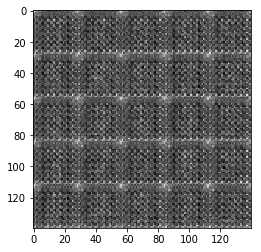

Epoch 1/2... Discriminator Loss: 1.2308... Generator Loss: 1.2112
Epoch 1/2... Discriminator Loss: 1.0061... Generator Loss: 1.7291
Epoch 1/2... Discriminator Loss: 1.0182... Generator Loss: 1.6341
Epoch 1/2... Discriminator Loss: 0.9633... Generator Loss: 1.7907
Epoch 1/2... Discriminator Loss: 0.9787... Generator Loss: 2.4471
Epoch 1/2... Discriminator Loss: 1.1238... Generator Loss: 1.6236
Epoch 1/2... Discriminator Loss: 1.1051... Generator Loss: 1.5257
Epoch 1/2... Discriminator Loss: 1.2431... Generator Loss: 1.6978
Epoch 1/2... Discriminator Loss: 1.2850... Generator Loss: 1.6056
Epoch 1/2... Discriminator Loss: 1.3713... Generator Loss: 1.2493


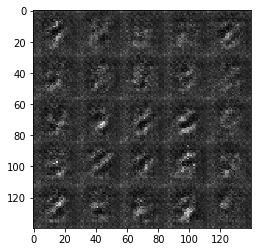

Epoch 1/2... Discriminator Loss: 1.2647... Generator Loss: 1.0602
Epoch 1/2... Discriminator Loss: 1.2466... Generator Loss: 1.3088
Epoch 1/2... Discriminator Loss: 1.1346... Generator Loss: 1.0534
Epoch 1/2... Discriminator Loss: 1.2666... Generator Loss: 1.1921
Epoch 1/2... Discriminator Loss: 1.3178... Generator Loss: 1.2145
Epoch 1/2... Discriminator Loss: 1.2394... Generator Loss: 1.7552
Epoch 1/2... Discriminator Loss: 1.4133... Generator Loss: 1.0535
Epoch 1/2... Discriminator Loss: 1.2465... Generator Loss: 2.0696
Epoch 1/2... Discriminator Loss: 1.4763... Generator Loss: 1.8905
Epoch 1/2... Discriminator Loss: 1.4155... Generator Loss: 0.6740


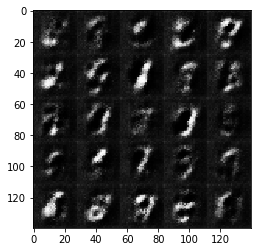

Epoch 1/2... Discriminator Loss: 1.1643... Generator Loss: 1.5471
Epoch 1/2... Discriminator Loss: 1.5916... Generator Loss: 0.9010
Epoch 1/2... Discriminator Loss: 0.8141... Generator Loss: 1.6458
Epoch 1/2... Discriminator Loss: 1.4000... Generator Loss: 1.3246
Epoch 1/2... Discriminator Loss: 1.0407... Generator Loss: 1.5550
Epoch 1/2... Discriminator Loss: 1.2792... Generator Loss: 1.0812
Epoch 1/2... Discriminator Loss: 1.4817... Generator Loss: 1.1154
Epoch 1/2... Discriminator Loss: 1.7289... Generator Loss: 2.3418
Epoch 1/2... Discriminator Loss: 1.4019... Generator Loss: 1.2069
Epoch 1/2... Discriminator Loss: 1.1378... Generator Loss: 1.6393


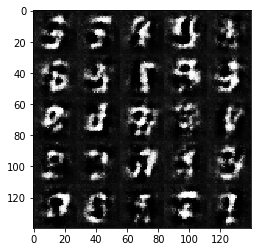

Epoch 1/2... Discriminator Loss: 1.6234... Generator Loss: 0.8390
Epoch 1/2... Discriminator Loss: 1.4541... Generator Loss: 1.5165
Epoch 1/2... Discriminator Loss: 1.4912... Generator Loss: 1.3472
Epoch 1/2... Discriminator Loss: 1.2621... Generator Loss: 1.0423
Epoch 1/2... Discriminator Loss: 1.5557... Generator Loss: 0.7415
Epoch 1/2... Discriminator Loss: 1.5151... Generator Loss: 0.8835
Epoch 1/2... Discriminator Loss: 1.3609... Generator Loss: 0.8887
Epoch 1/2... Discriminator Loss: 1.5392... Generator Loss: 1.8624
Epoch 1/2... Discriminator Loss: 1.6070... Generator Loss: 2.2921
Epoch 1/2... Discriminator Loss: 1.4699... Generator Loss: 1.2394


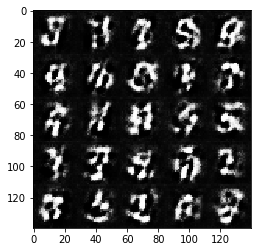

Epoch 1/2... Discriminator Loss: 1.2812... Generator Loss: 1.6873
Epoch 1/2... Discriminator Loss: 1.4787... Generator Loss: 0.8873
Epoch 1/2... Discriminator Loss: 1.6030... Generator Loss: 0.8902
Epoch 1/2... Discriminator Loss: 1.2797... Generator Loss: 1.0173
Epoch 1/2... Discriminator Loss: 1.1059... Generator Loss: 0.8406
Epoch 1/2... Discriminator Loss: 1.5056... Generator Loss: 1.2758
Epoch 1/2... Discriminator Loss: 1.3821... Generator Loss: 0.9822
Epoch 1/2... Discriminator Loss: 1.4167... Generator Loss: 1.3162
Epoch 1/2... Discriminator Loss: 1.5713... Generator Loss: 1.5437
Epoch 1/2... Discriminator Loss: 1.7615... Generator Loss: 0.9327


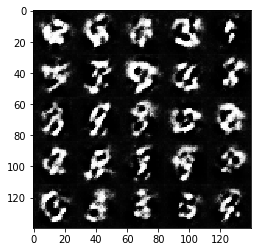

Epoch 1/2... Discriminator Loss: 1.4350... Generator Loss: 1.4920
Epoch 1/2... Discriminator Loss: 1.3642... Generator Loss: 1.2082
Epoch 1/2... Discriminator Loss: 1.3125... Generator Loss: 0.9775
Epoch 1/2... Discriminator Loss: 1.3161... Generator Loss: 1.1536
Epoch 1/2... Discriminator Loss: 1.3001... Generator Loss: 1.2368
Epoch 1/2... Discriminator Loss: 1.4181... Generator Loss: 0.5809
Epoch 1/2... Discriminator Loss: 1.5436... Generator Loss: 1.1499
Epoch 1/2... Discriminator Loss: 1.3773... Generator Loss: 1.2436
Epoch 1/2... Discriminator Loss: 1.4390... Generator Loss: 0.7671
Epoch 1/2... Discriminator Loss: 1.3123... Generator Loss: 1.7226


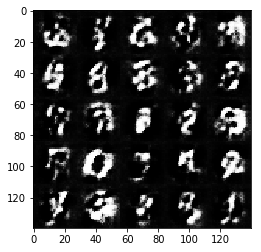

Epoch 1/2... Discriminator Loss: 1.2709... Generator Loss: 1.4112
Epoch 1/2... Discriminator Loss: 1.5055... Generator Loss: 1.3482
Epoch 1/2... Discriminator Loss: 1.3442... Generator Loss: 1.0035
Epoch 1/2... Discriminator Loss: 1.4457... Generator Loss: 0.8939
Epoch 1/2... Discriminator Loss: 1.2534... Generator Loss: 0.6815
Epoch 1/2... Discriminator Loss: 1.3856... Generator Loss: 1.0668
Epoch 1/2... Discriminator Loss: 1.3470... Generator Loss: 1.1539
Epoch 1/2... Discriminator Loss: 1.3528... Generator Loss: 2.0508
Epoch 1/2... Discriminator Loss: 1.4193... Generator Loss: 1.9490
Epoch 1/2... Discriminator Loss: 1.2683... Generator Loss: 1.6329


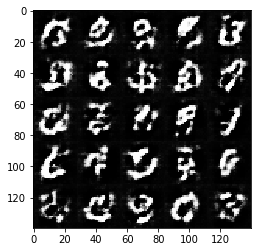

Epoch 1/2... Discriminator Loss: 1.5507... Generator Loss: 1.3595
Epoch 1/2... Discriminator Loss: 1.2424... Generator Loss: 0.7486
Epoch 1/2... Discriminator Loss: 1.3774... Generator Loss: 1.3617
Epoch 1/2... Discriminator Loss: 1.4084... Generator Loss: 0.9418
Epoch 1/2... Discriminator Loss: 1.1269... Generator Loss: 0.6593
Epoch 1/2... Discriminator Loss: 1.7612... Generator Loss: 0.6849
Epoch 1/2... Discriminator Loss: 1.4654... Generator Loss: 0.8526
Epoch 1/2... Discriminator Loss: 1.1638... Generator Loss: 1.1081
Epoch 1/2... Discriminator Loss: 1.2382... Generator Loss: 1.1076
Epoch 1/2... Discriminator Loss: 1.5255... Generator Loss: 1.2587


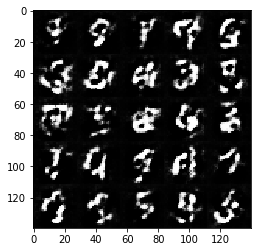

Epoch 1/2... Discriminator Loss: 1.4979... Generator Loss: 0.7406
Epoch 1/2... Discriminator Loss: 1.1016... Generator Loss: 0.9931
Epoch 1/2... Discriminator Loss: 1.2641... Generator Loss: 0.9656
Epoch 1/2... Discriminator Loss: 1.4583... Generator Loss: 1.0710
Epoch 1/2... Discriminator Loss: 1.3544... Generator Loss: 1.2148
Epoch 1/2... Discriminator Loss: 1.1988... Generator Loss: 1.4556
Epoch 1/2... Discriminator Loss: 1.2676... Generator Loss: 0.7666
Epoch 1/2... Discriminator Loss: 1.4070... Generator Loss: 1.1840
Epoch 1/2... Discriminator Loss: 1.3348... Generator Loss: 1.0959
Epoch 1/2... Discriminator Loss: 1.3207... Generator Loss: 0.8967


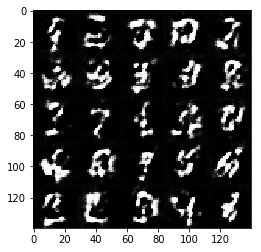

Epoch 1/2... Discriminator Loss: 1.2615... Generator Loss: 1.5914
Epoch 1/2... Discriminator Loss: 1.3660... Generator Loss: 1.2685
Epoch 1/2... Discriminator Loss: 1.4260... Generator Loss: 1.5866
Epoch 1/2... Discriminator Loss: 1.4049... Generator Loss: 1.2594
Epoch 1/2... Discriminator Loss: 1.2559... Generator Loss: 1.0422
Epoch 1/2... Discriminator Loss: 1.2675... Generator Loss: 0.8759
Epoch 1/2... Discriminator Loss: 1.4094... Generator Loss: 1.1386
Epoch 1/2... Discriminator Loss: 1.5905... Generator Loss: 1.6934
Epoch 1/2... Discriminator Loss: 1.3393... Generator Loss: 1.0256
Epoch 1/2... Discriminator Loss: 1.2909... Generator Loss: 1.1216


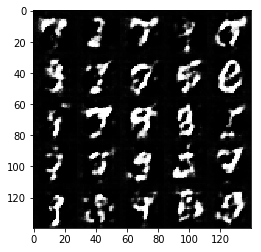

Epoch 1/2... Discriminator Loss: 1.2172... Generator Loss: 0.8353
Epoch 1/2... Discriminator Loss: 1.3590... Generator Loss: 1.2359
Epoch 1/2... Discriminator Loss: 1.3721... Generator Loss: 1.0405
Epoch 1/2... Discriminator Loss: 1.5662... Generator Loss: 1.2223
Epoch 1/2... Discriminator Loss: 1.4151... Generator Loss: 1.9069
Epoch 1/2... Discriminator Loss: 1.2795... Generator Loss: 0.9837
Epoch 1/2... Discriminator Loss: 1.4185... Generator Loss: 1.2855
Epoch 1/2... Discriminator Loss: 1.5371... Generator Loss: 1.4256
Epoch 1/2... Discriminator Loss: 1.1803... Generator Loss: 0.9596
Epoch 1/2... Discriminator Loss: 1.2021... Generator Loss: 1.2798


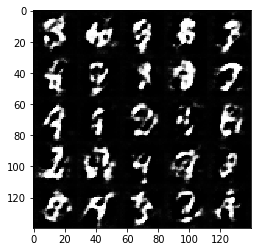

Epoch 1/2... Discriminator Loss: 1.5042... Generator Loss: 1.0739
Epoch 1/2... Discriminator Loss: 1.2681... Generator Loss: 1.0720
Epoch 1/2... Discriminator Loss: 1.6592... Generator Loss: 1.4873
Epoch 1/2... Discriminator Loss: 1.3120... Generator Loss: 1.6027
Epoch 1/2... Discriminator Loss: 1.1934... Generator Loss: 1.0990
Epoch 1/2... Discriminator Loss: 1.1352... Generator Loss: 0.8742
Epoch 1/2... Discriminator Loss: 1.2321... Generator Loss: 1.0619
Epoch 1/2... Discriminator Loss: 1.3154... Generator Loss: 1.1563
Epoch 1/2... Discriminator Loss: 1.4387... Generator Loss: 0.8402
Epoch 1/2... Discriminator Loss: 1.3816... Generator Loss: 1.0996


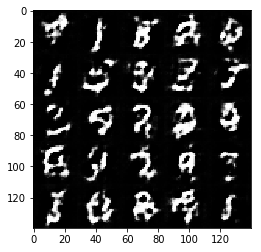

Epoch 1/2... Discriminator Loss: 1.3424... Generator Loss: 1.2216
Epoch 1/2... Discriminator Loss: 1.3487... Generator Loss: 1.1338
Epoch 1/2... Discriminator Loss: 1.5478... Generator Loss: 1.2296
Epoch 1/2... Discriminator Loss: 1.3104... Generator Loss: 1.0882
Epoch 1/2... Discriminator Loss: 1.3194... Generator Loss: 0.9130
Epoch 1/2... Discriminator Loss: 1.7616... Generator Loss: 0.9898
Epoch 1/2... Discriminator Loss: 1.3717... Generator Loss: 1.3236
Epoch 1/2... Discriminator Loss: 1.6672... Generator Loss: 0.8018
Epoch 1/2... Discriminator Loss: 1.6196... Generator Loss: 1.5743
Epoch 1/2... Discriminator Loss: 1.1669... Generator Loss: 1.2995


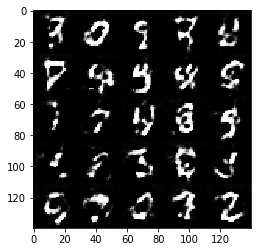

Epoch 1/2... Discriminator Loss: 1.6498... Generator Loss: 0.8973
Epoch 1/2... Discriminator Loss: 1.2434... Generator Loss: 0.9702
Epoch 1/2... Discriminator Loss: 1.1504... Generator Loss: 1.4235
Epoch 1/2... Discriminator Loss: 1.2776... Generator Loss: 1.2543
Epoch 1/2... Discriminator Loss: 1.4046... Generator Loss: 1.0433
Epoch 1/2... Discriminator Loss: 1.4281... Generator Loss: 1.2118
Epoch 1/2... Discriminator Loss: 1.4198... Generator Loss: 1.0093
Epoch 1/2... Discriminator Loss: 1.3898... Generator Loss: 0.8366
Epoch 1/2... Discriminator Loss: 1.4010... Generator Loss: 0.8650
Epoch 1/2... Discriminator Loss: 1.5636... Generator Loss: 0.9268


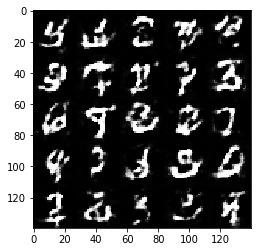

Epoch 1/2... Discriminator Loss: 1.3674... Generator Loss: 1.2953
Epoch 1/2... Discriminator Loss: 1.2279... Generator Loss: 0.9947
Epoch 1/2... Discriminator Loss: 1.3207... Generator Loss: 1.0862
Epoch 1/2... Discriminator Loss: 1.4826... Generator Loss: 1.0318
Epoch 1/2... Discriminator Loss: 1.5897... Generator Loss: 0.8689
Epoch 1/2... Discriminator Loss: 1.3254... Generator Loss: 0.7797
Epoch 1/2... Discriminator Loss: 1.1821... Generator Loss: 0.8445
Epoch 1/2... Discriminator Loss: 1.3032... Generator Loss: 1.1219
Epoch 1/2... Discriminator Loss: 1.1482... Generator Loss: 1.3894
Epoch 1/2... Discriminator Loss: 1.2895... Generator Loss: 1.2911


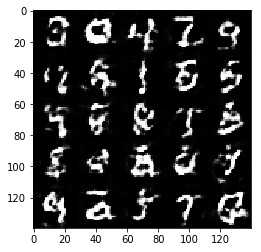

Epoch 1/2... Discriminator Loss: 1.1474... Generator Loss: 1.3900
Epoch 1/2... Discriminator Loss: 1.4610... Generator Loss: 1.6616
Epoch 1/2... Discriminator Loss: 1.3242... Generator Loss: 0.5893
Epoch 1/2... Discriminator Loss: 1.1759... Generator Loss: 1.0011
Epoch 1/2... Discriminator Loss: 1.0663... Generator Loss: 1.0569
Epoch 1/2... Discriminator Loss: 1.4186... Generator Loss: 1.3730
Epoch 1/2... Discriminator Loss: 1.7126... Generator Loss: 0.6648
Epoch 1/2... Discriminator Loss: 1.1711... Generator Loss: 0.9888
Epoch 1/2... Discriminator Loss: 1.2823... Generator Loss: 1.2090
Epoch 1/2... Discriminator Loss: 1.3612... Generator Loss: 0.7003


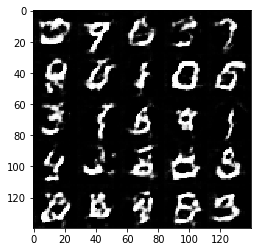

Epoch 1/2... Discriminator Loss: 1.1549... Generator Loss: 1.3665
Epoch 1/2... Discriminator Loss: 1.2519... Generator Loss: 1.1338
Epoch 1/2... Discriminator Loss: 1.4159... Generator Loss: 0.9789
Epoch 1/2... Discriminator Loss: 1.4516... Generator Loss: 0.8900
Epoch 1/2... Discriminator Loss: 1.2625... Generator Loss: 0.9945
Epoch 1/2... Discriminator Loss: 1.3902... Generator Loss: 1.0921
Epoch 1/2... Discriminator Loss: 1.2977... Generator Loss: 1.3675
Epoch 1/2... Discriminator Loss: 1.4164... Generator Loss: 1.0493
Epoch 1/2... Discriminator Loss: 1.2978... Generator Loss: 1.2902
Epoch 1/2... Discriminator Loss: 1.7758... Generator Loss: 0.5940


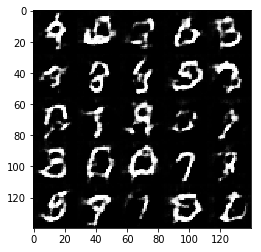

Epoch 1/2... Discriminator Loss: 1.4371... Generator Loss: 1.2389
Epoch 1/2... Discriminator Loss: 1.4389... Generator Loss: 0.9894
Epoch 1/2... Discriminator Loss: 1.3602... Generator Loss: 1.0301
Epoch 1/2... Discriminator Loss: 1.1510... Generator Loss: 0.8400
Epoch 1/2... Discriminator Loss: 1.4815... Generator Loss: 0.9165
Epoch 1/2... Discriminator Loss: 1.4760... Generator Loss: 1.3184
Epoch 1/2... Discriminator Loss: 1.4316... Generator Loss: 0.8721
Epoch 2/2... Discriminator Loss: 1.2615... Generator Loss: 0.8957
Epoch 2/2... Discriminator Loss: 1.3228... Generator Loss: 0.9677
Epoch 2/2... Discriminator Loss: 1.1348... Generator Loss: 1.4540


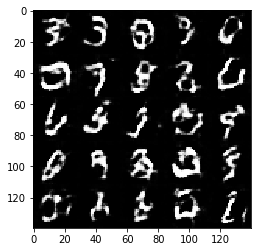

Epoch 2/2... Discriminator Loss: 1.6075... Generator Loss: 0.8002
Epoch 2/2... Discriminator Loss: 1.6456... Generator Loss: 0.6730
Epoch 2/2... Discriminator Loss: 1.1749... Generator Loss: 1.1334
Epoch 2/2... Discriminator Loss: 1.6039... Generator Loss: 0.9930
Epoch 2/2... Discriminator Loss: 1.3382... Generator Loss: 1.1762
Epoch 2/2... Discriminator Loss: 1.2979... Generator Loss: 1.3028
Epoch 2/2... Discriminator Loss: 1.2137... Generator Loss: 1.0595
Epoch 2/2... Discriminator Loss: 1.4788... Generator Loss: 0.9119
Epoch 2/2... Discriminator Loss: 1.3712... Generator Loss: 1.1441
Epoch 2/2... Discriminator Loss: 1.3781... Generator Loss: 0.7928


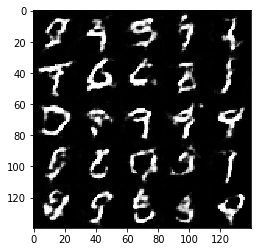

Epoch 2/2... Discriminator Loss: 1.3531... Generator Loss: 0.9690
Epoch 2/2... Discriminator Loss: 1.3844... Generator Loss: 1.0503
Epoch 2/2... Discriminator Loss: 1.4310... Generator Loss: 1.0629
Epoch 2/2... Discriminator Loss: 1.5075... Generator Loss: 0.8207
Epoch 2/2... Discriminator Loss: 1.6108... Generator Loss: 0.9813
Epoch 2/2... Discriminator Loss: 1.7110... Generator Loss: 0.7903
Epoch 2/2... Discriminator Loss: 1.2563... Generator Loss: 0.8527
Epoch 2/2... Discriminator Loss: 1.3090... Generator Loss: 0.7731
Epoch 2/2... Discriminator Loss: 1.2531... Generator Loss: 0.8424
Epoch 2/2... Discriminator Loss: 1.7235... Generator Loss: 0.9024


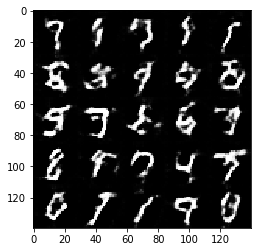

Epoch 2/2... Discriminator Loss: 1.3283... Generator Loss: 0.9303
Epoch 2/2... Discriminator Loss: 1.4544... Generator Loss: 0.8641
Epoch 2/2... Discriminator Loss: 1.1914... Generator Loss: 0.9151
Epoch 2/2... Discriminator Loss: 1.1702... Generator Loss: 1.0368
Epoch 2/2... Discriminator Loss: 1.3109... Generator Loss: 0.9456
Epoch 2/2... Discriminator Loss: 1.3802... Generator Loss: 1.0390
Epoch 2/2... Discriminator Loss: 1.6129... Generator Loss: 0.7953
Epoch 2/2... Discriminator Loss: 1.4672... Generator Loss: 0.6956
Epoch 2/2... Discriminator Loss: 1.3051... Generator Loss: 0.8851
Epoch 2/2... Discriminator Loss: 1.4858... Generator Loss: 0.7989


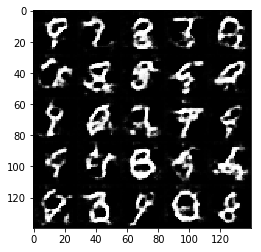

Epoch 2/2... Discriminator Loss: 1.4326... Generator Loss: 1.1277
Epoch 2/2... Discriminator Loss: 1.2661... Generator Loss: 0.8630
Epoch 2/2... Discriminator Loss: 1.2975... Generator Loss: 1.0766
Epoch 2/2... Discriminator Loss: 1.3930... Generator Loss: 1.3419
Epoch 2/2... Discriminator Loss: 1.4109... Generator Loss: 0.9394
Epoch 2/2... Discriminator Loss: 1.3500... Generator Loss: 1.2292
Epoch 2/2... Discriminator Loss: 1.3240... Generator Loss: 0.8669
Epoch 2/2... Discriminator Loss: 1.3757... Generator Loss: 0.8816
Epoch 2/2... Discriminator Loss: 1.4062... Generator Loss: 0.6386
Epoch 2/2... Discriminator Loss: 1.6051... Generator Loss: 0.9976


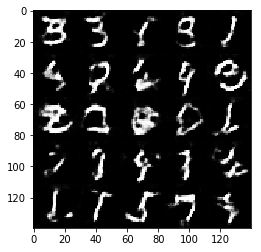

Epoch 2/2... Discriminator Loss: 1.4121... Generator Loss: 0.8092
Epoch 2/2... Discriminator Loss: 1.2858... Generator Loss: 0.8850
Epoch 2/2... Discriminator Loss: 1.4514... Generator Loss: 1.0401
Epoch 2/2... Discriminator Loss: 1.2808... Generator Loss: 0.9705
Epoch 2/2... Discriminator Loss: 1.1413... Generator Loss: 1.0190
Epoch 2/2... Discriminator Loss: 1.4172... Generator Loss: 0.7346
Epoch 2/2... Discriminator Loss: 1.3344... Generator Loss: 0.8519
Epoch 2/2... Discriminator Loss: 1.3353... Generator Loss: 0.8812
Epoch 2/2... Discriminator Loss: 1.3951... Generator Loss: 0.8503
Epoch 2/2... Discriminator Loss: 1.2032... Generator Loss: 1.0093


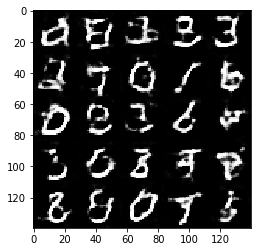

Epoch 2/2... Discriminator Loss: 1.5577... Generator Loss: 0.8294
Epoch 2/2... Discriminator Loss: 1.3349... Generator Loss: 0.7936
Epoch 2/2... Discriminator Loss: 1.4276... Generator Loss: 0.9884
Epoch 2/2... Discriminator Loss: 1.1411... Generator Loss: 1.0229
Epoch 2/2... Discriminator Loss: 1.2954... Generator Loss: 1.0277
Epoch 2/2... Discriminator Loss: 1.5203... Generator Loss: 1.0664
Epoch 2/2... Discriminator Loss: 1.4532... Generator Loss: 0.8182
Epoch 2/2... Discriminator Loss: 1.2856... Generator Loss: 1.2573
Epoch 2/2... Discriminator Loss: 1.2002... Generator Loss: 0.9503
Epoch 2/2... Discriminator Loss: 1.3110... Generator Loss: 0.8002


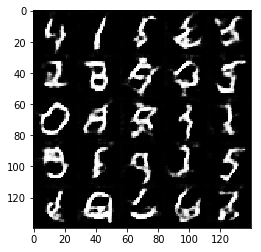

Epoch 2/2... Discriminator Loss: 1.5272... Generator Loss: 1.0113
Epoch 2/2... Discriminator Loss: 1.4536... Generator Loss: 0.9836
Epoch 2/2... Discriminator Loss: 1.3981... Generator Loss: 0.8806
Epoch 2/2... Discriminator Loss: 1.3397... Generator Loss: 0.9149
Epoch 2/2... Discriminator Loss: 1.4281... Generator Loss: 0.6408
Epoch 2/2... Discriminator Loss: 1.2314... Generator Loss: 1.1530
Epoch 2/2... Discriminator Loss: 1.4284... Generator Loss: 0.7112
Epoch 2/2... Discriminator Loss: 1.3592... Generator Loss: 0.7449
Epoch 2/2... Discriminator Loss: 1.2239... Generator Loss: 1.0066
Epoch 2/2... Discriminator Loss: 1.4244... Generator Loss: 0.7013


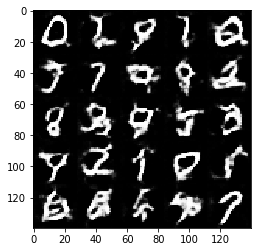

Epoch 2/2... Discriminator Loss: 1.3638... Generator Loss: 0.7613
Epoch 2/2... Discriminator Loss: 1.4000... Generator Loss: 1.0147
Epoch 2/2... Discriminator Loss: 1.2930... Generator Loss: 1.1129
Epoch 2/2... Discriminator Loss: 1.4479... Generator Loss: 1.0195
Epoch 2/2... Discriminator Loss: 1.4862... Generator Loss: 0.6620
Epoch 2/2... Discriminator Loss: 1.2863... Generator Loss: 0.7879
Epoch 2/2... Discriminator Loss: 1.4470... Generator Loss: 0.8324
Epoch 2/2... Discriminator Loss: 1.5206... Generator Loss: 0.8409
Epoch 2/2... Discriminator Loss: 1.4728... Generator Loss: 0.9965
Epoch 2/2... Discriminator Loss: 1.3236... Generator Loss: 0.8822


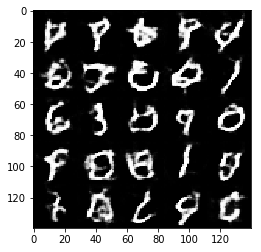

Epoch 2/2... Discriminator Loss: 1.4901... Generator Loss: 0.7405
Epoch 2/2... Discriminator Loss: 1.5973... Generator Loss: 0.7732
Epoch 2/2... Discriminator Loss: 1.4736... Generator Loss: 0.9602
Epoch 2/2... Discriminator Loss: 1.2440... Generator Loss: 1.0903
Epoch 2/2... Discriminator Loss: 1.3667... Generator Loss: 0.7227
Epoch 2/2... Discriminator Loss: 1.3893... Generator Loss: 0.8976
Epoch 2/2... Discriminator Loss: 1.3670... Generator Loss: 0.9634
Epoch 2/2... Discriminator Loss: 1.5916... Generator Loss: 1.0462
Epoch 2/2... Discriminator Loss: 1.4134... Generator Loss: 0.8566
Epoch 2/2... Discriminator Loss: 1.3180... Generator Loss: 0.9247


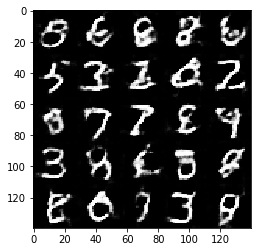

Epoch 2/2... Discriminator Loss: 1.2863... Generator Loss: 1.2311
Epoch 2/2... Discriminator Loss: 1.1763... Generator Loss: 0.9079
Epoch 2/2... Discriminator Loss: 1.4074... Generator Loss: 1.1375
Epoch 2/2... Discriminator Loss: 1.3055... Generator Loss: 0.8809
Epoch 2/2... Discriminator Loss: 1.2601... Generator Loss: 1.0114
Epoch 2/2... Discriminator Loss: 1.2006... Generator Loss: 1.0847
Epoch 2/2... Discriminator Loss: 1.4376... Generator Loss: 0.7600
Epoch 2/2... Discriminator Loss: 1.3534... Generator Loss: 0.9124
Epoch 2/2... Discriminator Loss: 1.2061... Generator Loss: 0.9064
Epoch 2/2... Discriminator Loss: 1.2828... Generator Loss: 0.9129


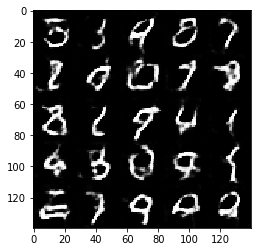

Epoch 2/2... Discriminator Loss: 1.2725... Generator Loss: 0.7285
Epoch 2/2... Discriminator Loss: 1.3513... Generator Loss: 1.0313
Epoch 2/2... Discriminator Loss: 1.2537... Generator Loss: 1.0352
Epoch 2/2... Discriminator Loss: 1.3008... Generator Loss: 1.0749
Epoch 2/2... Discriminator Loss: 1.3598... Generator Loss: 0.9161
Epoch 2/2... Discriminator Loss: 1.6464... Generator Loss: 0.6994
Epoch 2/2... Discriminator Loss: 1.2280... Generator Loss: 0.8661
Epoch 2/2... Discriminator Loss: 1.5353... Generator Loss: 0.9285
Epoch 2/2... Discriminator Loss: 1.3599... Generator Loss: 0.9139
Epoch 2/2... Discriminator Loss: 1.3667... Generator Loss: 0.9482


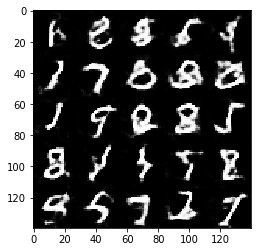

Epoch 2/2... Discriminator Loss: 1.3063... Generator Loss: 0.9718
Epoch 2/2... Discriminator Loss: 1.2475... Generator Loss: 0.9834
Epoch 2/2... Discriminator Loss: 1.3027... Generator Loss: 0.8759
Epoch 2/2... Discriminator Loss: 1.3800... Generator Loss: 1.0935
Epoch 2/2... Discriminator Loss: 1.5105... Generator Loss: 1.0401
Epoch 2/2... Discriminator Loss: 1.2848... Generator Loss: 0.8037
Epoch 2/2... Discriminator Loss: 1.3187... Generator Loss: 0.8612
Epoch 2/2... Discriminator Loss: 1.4870... Generator Loss: 0.8337
Epoch 2/2... Discriminator Loss: 1.4013... Generator Loss: 0.8850
Epoch 2/2... Discriminator Loss: 1.5035... Generator Loss: 1.0156


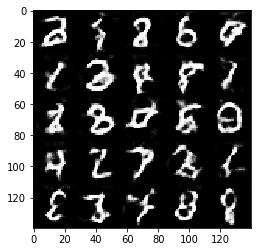

Epoch 2/2... Discriminator Loss: 1.4998... Generator Loss: 0.9744
Epoch 2/2... Discriminator Loss: 1.3369... Generator Loss: 1.0423
Epoch 2/2... Discriminator Loss: 1.3145... Generator Loss: 0.6195
Epoch 2/2... Discriminator Loss: 1.3242... Generator Loss: 0.8505
Epoch 2/2... Discriminator Loss: 1.3344... Generator Loss: 0.9213
Epoch 2/2... Discriminator Loss: 1.3786... Generator Loss: 0.8798
Epoch 2/2... Discriminator Loss: 1.4324... Generator Loss: 0.9399
Epoch 2/2... Discriminator Loss: 1.3075... Generator Loss: 0.8899
Epoch 2/2... Discriminator Loss: 1.5815... Generator Loss: 0.6469
Epoch 2/2... Discriminator Loss: 1.3003... Generator Loss: 0.8244


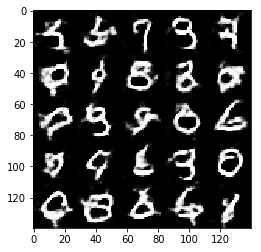

Epoch 2/2... Discriminator Loss: 1.3709... Generator Loss: 0.8222
Epoch 2/2... Discriminator Loss: 1.1437... Generator Loss: 0.8771
Epoch 2/2... Discriminator Loss: 1.3190... Generator Loss: 1.0981
Epoch 2/2... Discriminator Loss: 1.4027... Generator Loss: 0.9740
Epoch 2/2... Discriminator Loss: 1.2884... Generator Loss: 0.9439
Epoch 2/2... Discriminator Loss: 1.2697... Generator Loss: 0.9234
Epoch 2/2... Discriminator Loss: 1.3837... Generator Loss: 0.7325
Epoch 2/2... Discriminator Loss: 1.4762... Generator Loss: 0.7133
Epoch 2/2... Discriminator Loss: 1.3797... Generator Loss: 0.7569
Epoch 2/2... Discriminator Loss: 1.4056... Generator Loss: 1.0458


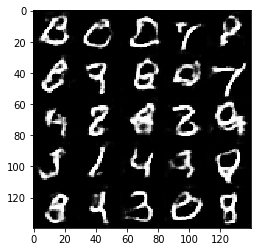

Epoch 2/2... Discriminator Loss: 1.1237... Generator Loss: 0.9970
Epoch 2/2... Discriminator Loss: 1.2201... Generator Loss: 0.8811
Epoch 2/2... Discriminator Loss: 1.4766... Generator Loss: 1.0547
Epoch 2/2... Discriminator Loss: 1.3223... Generator Loss: 0.9604
Epoch 2/2... Discriminator Loss: 1.4997... Generator Loss: 1.1044
Epoch 2/2... Discriminator Loss: 1.3047... Generator Loss: 1.0514
Epoch 2/2... Discriminator Loss: 1.3587... Generator Loss: 0.9345
Epoch 2/2... Discriminator Loss: 1.2787... Generator Loss: 0.7021
Epoch 2/2... Discriminator Loss: 1.3926... Generator Loss: 0.9010
Epoch 2/2... Discriminator Loss: 1.2444... Generator Loss: 0.8776


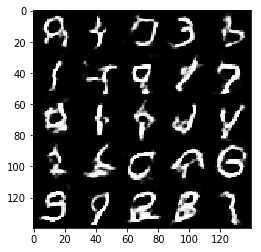

Epoch 2/2... Discriminator Loss: 1.3922... Generator Loss: 0.9473
Epoch 2/2... Discriminator Loss: 1.4571... Generator Loss: 0.8789
Epoch 2/2... Discriminator Loss: 1.4653... Generator Loss: 0.7779
Epoch 2/2... Discriminator Loss: 1.3248... Generator Loss: 0.6667
Epoch 2/2... Discriminator Loss: 1.3861... Generator Loss: 0.9357
Epoch 2/2... Discriminator Loss: 1.2091... Generator Loss: 0.8719
Epoch 2/2... Discriminator Loss: 1.3247... Generator Loss: 1.0530
Epoch 2/2... Discriminator Loss: 1.2543... Generator Loss: 0.8319
Epoch 2/2... Discriminator Loss: 1.2891... Generator Loss: 0.9951
Epoch 2/2... Discriminator Loss: 1.4941... Generator Loss: 0.7465


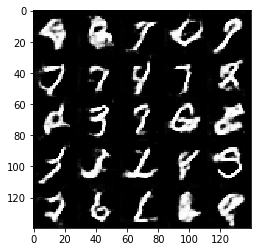

Epoch 2/2... Discriminator Loss: 1.3099... Generator Loss: 1.0755
Epoch 2/2... Discriminator Loss: 1.4604... Generator Loss: 0.8916
Epoch 2/2... Discriminator Loss: 1.2314... Generator Loss: 0.7201
Epoch 2/2... Discriminator Loss: 1.2492... Generator Loss: 0.8727
Epoch 2/2... Discriminator Loss: 1.4766... Generator Loss: 0.8482
Epoch 2/2... Discriminator Loss: 1.4013... Generator Loss: 0.8317
Epoch 2/2... Discriminator Loss: 1.2373... Generator Loss: 0.9420
Epoch 2/2... Discriminator Loss: 1.2148... Generator Loss: 0.9349
Epoch 2/2... Discriminator Loss: 1.3927... Generator Loss: 0.7313
Epoch 2/2... Discriminator Loss: 1.4960... Generator Loss: 1.0299


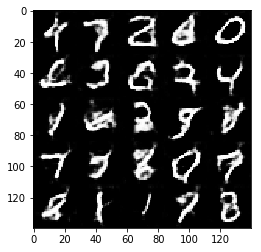

Epoch 2/2... Discriminator Loss: 1.7622... Generator Loss: 0.8377
Epoch 2/2... Discriminator Loss: 1.3113... Generator Loss: 0.9852
Epoch 2/2... Discriminator Loss: 1.2244... Generator Loss: 0.8144
Epoch 2/2... Discriminator Loss: 1.3800... Generator Loss: 1.0128
Epoch 2/2... Discriminator Loss: 1.6176... Generator Loss: 0.7472
Epoch 2/2... Discriminator Loss: 1.2300... Generator Loss: 0.9151
Epoch 2/2... Discriminator Loss: 1.4600... Generator Loss: 0.8454
Epoch 2/2... Discriminator Loss: 1.4999... Generator Loss: 0.9863
Epoch 2/2... Discriminator Loss: 1.2195... Generator Loss: 1.1284
Epoch 2/2... Discriminator Loss: 1.3322... Generator Loss: 0.8352


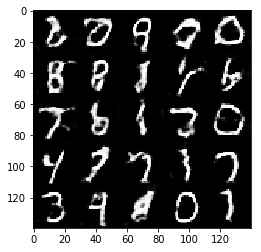

Epoch 2/2... Discriminator Loss: 1.4701... Generator Loss: 0.8883
Epoch 2/2... Discriminator Loss: 1.2960... Generator Loss: 0.9165
Epoch 2/2... Discriminator Loss: 1.4633... Generator Loss: 1.1958
Epoch 2/2... Discriminator Loss: 1.3449... Generator Loss: 0.9112
Epoch 2/2... Discriminator Loss: 1.2737... Generator Loss: 1.1203


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.7919... Generator Loss: 1.4710
Epoch 1/1... Discriminator Loss: 1.8949... Generator Loss: 1.8510
Epoch 1/1... Discriminator Loss: 1.9706... Generator Loss: 1.8042
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 1.7047
Epoch 1/1... Discriminator Loss: 1.5271... Generator Loss: 1.8884
Epoch 1/1... Discriminator Loss: 1.9986... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 1.0302
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 2.0128
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 1.1193
Epoch 1/1... Discriminator Loss: 1.6612... Generator Loss: 0.6615


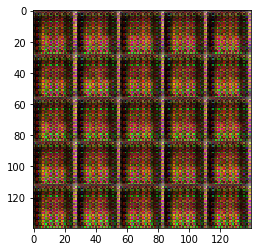

Epoch 1/1... Discriminator Loss: 0.7262... Generator Loss: 2.2347
Epoch 1/1... Discriminator Loss: 1.6720... Generator Loss: 2.4719
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 1.1898
Epoch 1/1... Discriminator Loss: 1.5122... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.6100... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.9402... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.8069... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.5945


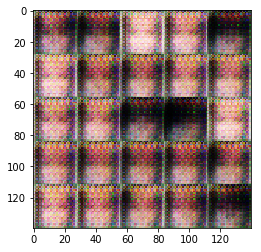

Epoch 1/1... Discriminator Loss: 1.9788... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.6548... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 1.5572... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.6145... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.5432... Generator Loss: 1.0083
Epoch 1/1... Discriminator Loss: 1.5182... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.5953... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.9686
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.6645


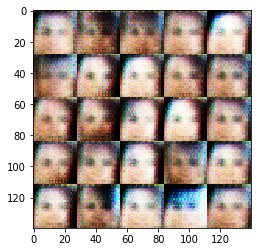

Epoch 1/1... Discriminator Loss: 1.5277... Generator Loss: 1.0150
Epoch 1/1... Discriminator Loss: 1.6283... Generator Loss: 1.1717
Epoch 1/1... Discriminator Loss: 1.7651... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.6291... Generator Loss: 1.0271
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.9259
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.5525... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.7147


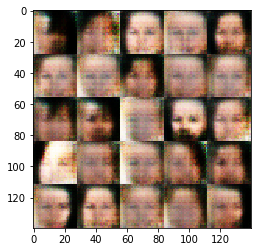

Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.5422... Generator Loss: 0.8466
Epoch 1/1... Discriminator Loss: 1.5501... Generator Loss: 0.5833
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.9834
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 1.1744
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 1.1816
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.9849


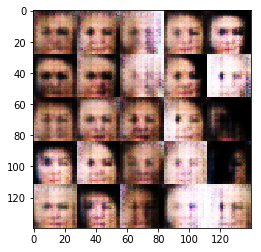

Epoch 1/1... Discriminator Loss: 1.5923... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.5563... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 1.1608
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.4575
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.9104
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 1.3052
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.4953... Generator Loss: 0.5888


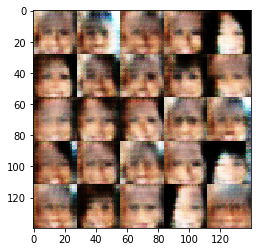

Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.5697
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 2.6990... Generator Loss: 0.1586
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 1.0409
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.9460
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.9565
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.8010


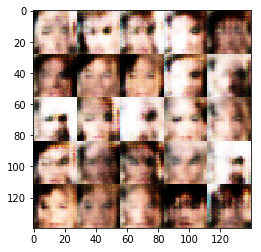

Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 1.4590
Epoch 1/1... Discriminator Loss: 1.5531... Generator Loss: 0.9581
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.9660
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.8877
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 1.2963


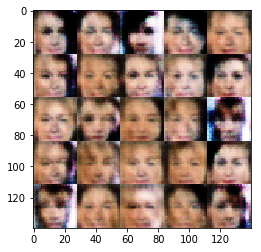

Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 1.0336
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 1.2932
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 1.2085
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.8644
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.9759
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 2.1492


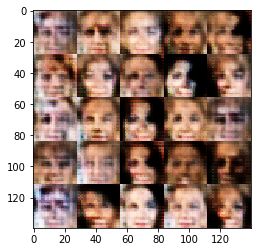

Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.5884
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.0538... Generator Loss: 1.3434
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.8657
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.9008
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.9506
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.9845
Epoch 1/1... Discriminator Loss: 1.8377... Generator Loss: 0.3285


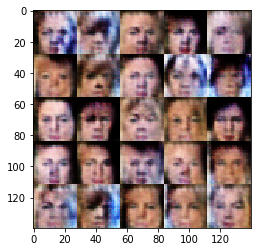

Epoch 1/1... Discriminator Loss: 1.5354... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 1.0679
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.9812
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 0.9200
Epoch 1/1... Discriminator Loss: 1.8181... Generator Loss: 0.4702
Epoch 1/1... Discriminator Loss: 1.7921... Generator Loss: 1.5361
Epoch 1/1... Discriminator Loss: 1.6991... Generator Loss: 0.4563
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 1.5927... Generator Loss: 0.7411


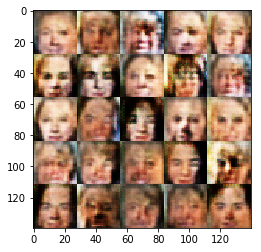

Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.5344
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.6147... Generator Loss: 0.5330
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.4636
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 1.2783
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 1.0478
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.5629... Generator Loss: 0.5249
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.9132


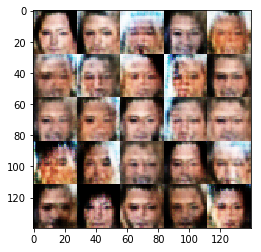

Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 1.1649
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 1.0697
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.4969... Generator Loss: 0.9374
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 1.0513
Epoch 1/1... Discriminator Loss: 1.4990... Generator Loss: 0.5311
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.9486


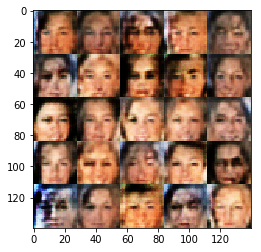

Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.9414
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.8943
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 1.0438
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.5233
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.8984
Epoch 1/1... Discriminator Loss: 1.5690... Generator Loss: 0.4005


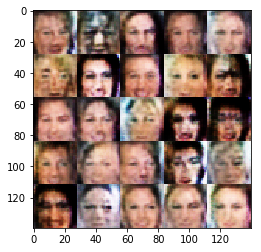

Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.3795
Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.6273
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.5959... Generator Loss: 0.5757
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.9383
Epoch 1/1... Discriminator Loss: 1.1754... Generator Loss: 0.8809


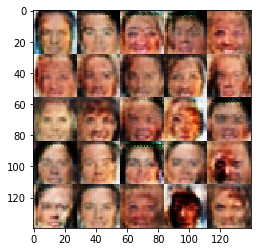

Epoch 1/1... Discriminator Loss: 1.5812... Generator Loss: 0.5075
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.5091... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.5352
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.5907
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.6809... Generator Loss: 1.0948
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.6141... Generator Loss: 0.3547


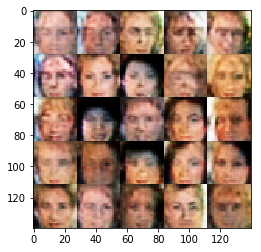

Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.4025
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.9964
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.5202... Generator Loss: 0.5199
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.5953... Generator Loss: 0.3963


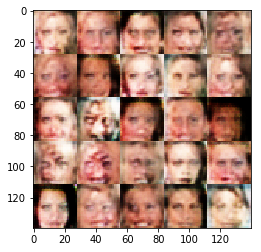

Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 1.5310... Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 1.2705
Epoch 1/1... Discriminator Loss: 1.5207... Generator Loss: 1.0047
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.5481... Generator Loss: 0.4801


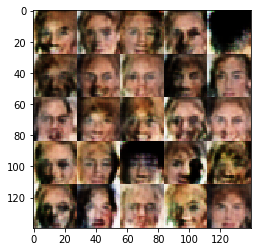

Epoch 1/1... Discriminator Loss: 1.8507... Generator Loss: 1.3416
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.5784... Generator Loss: 0.4275
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.5658


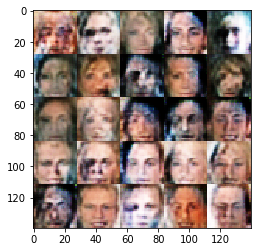

Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 1.1127
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 0.9480
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.5686... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.8673
Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 0.7295


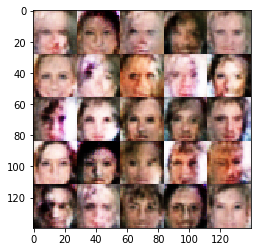

Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.9078
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.9135
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 1.1936
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.8640
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.8841


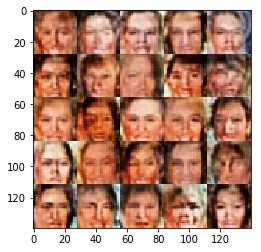

Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.5667
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.8330


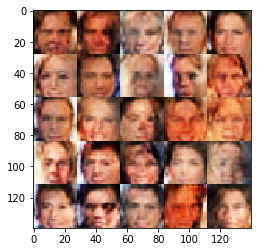

Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.8895
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.5635
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.9999
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.4556
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.5930
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.7559


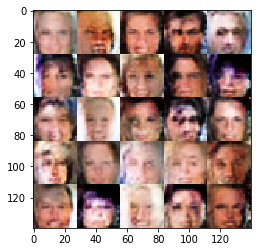

Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.0227... Generator Loss: 1.2332
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.6078
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.8571
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.9117
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.9352


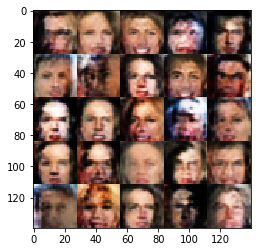

Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.5356
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.4811... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 1.0410


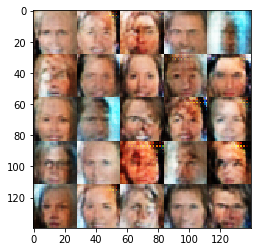

Epoch 1/1... Discriminator Loss: 1.5478... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.7524


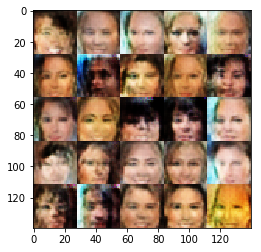

Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.5792
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.6383


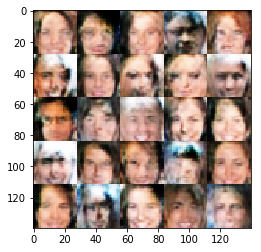

Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.5905
Epoch 1/1... Discriminator Loss: 1.4969... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 1.3083
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 1.1224
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.9194
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.7524


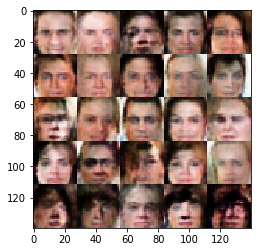

Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.9690
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.9183
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.9222
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.6486


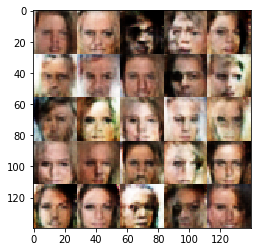

Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.8635
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.6073


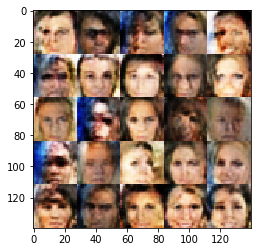

Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.5602
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.6425


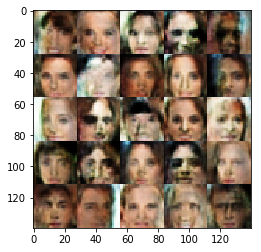

Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.9129
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.7387


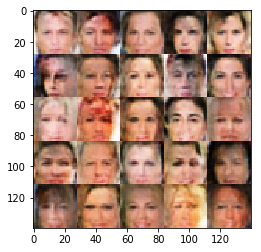

Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.9455
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.5996
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.9826
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.7291


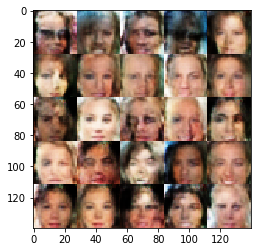

Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.7799


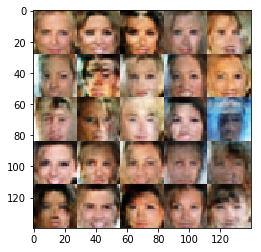

Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.5303... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.7948


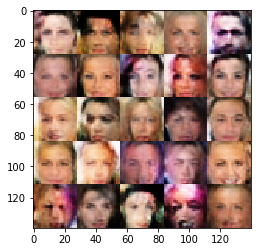

Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.5719
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.5469
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7663


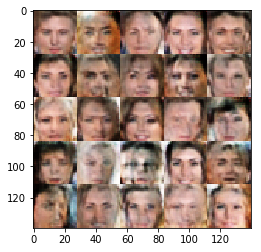

Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.9079
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.8000


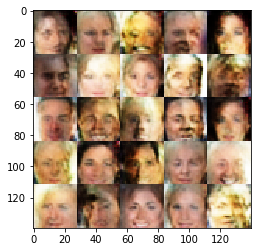

Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.9587
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7964


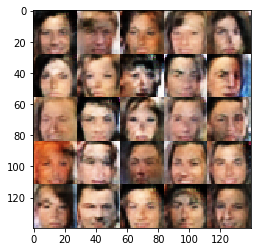

Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.6980


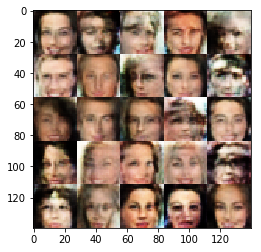

Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.4885... Generator Loss: 0.5511
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.8848
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.9290
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7456


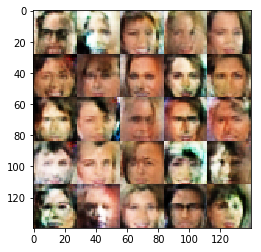

Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.9756
Epoch 1/1... Discriminator Loss: 1.5187... Generator Loss: 0.5602
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.5814


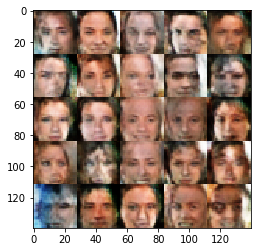

Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.8689
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.6327


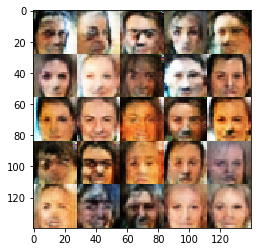

Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.8189


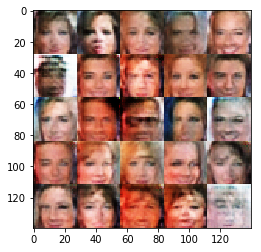

Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.5852
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.9893
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.7163


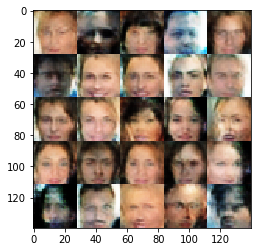

Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.6714


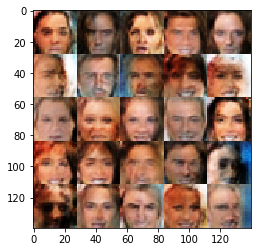

Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.7496


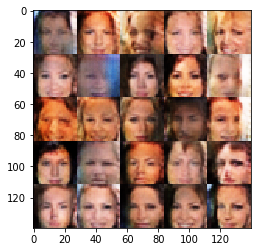

Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.7263


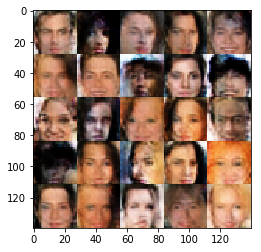

Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.6669


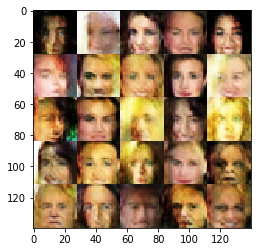

Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.7865


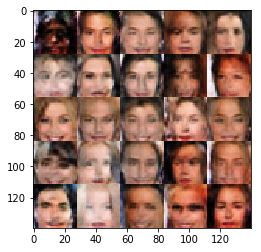

Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.6231
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.6304


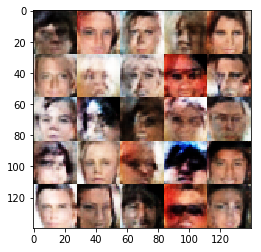

Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.8784
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 1.0013
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.6120


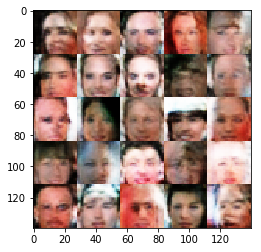

Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7288


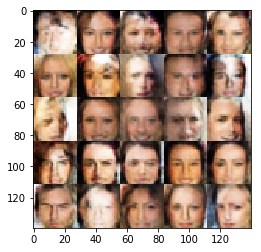

Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.6828


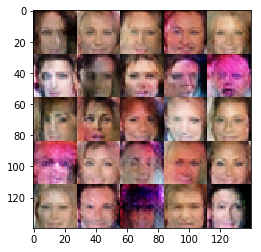

Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.4999... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.7009


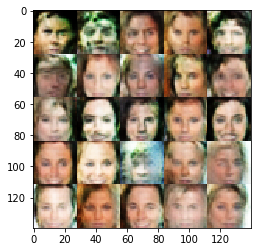

Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.5565
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.6378


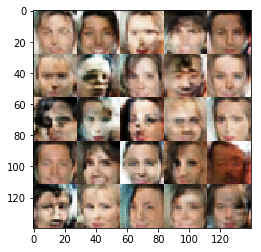

Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.7697


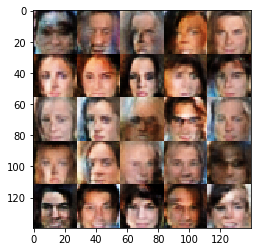

Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7322


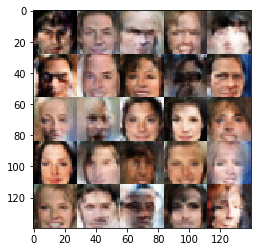

Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.8023


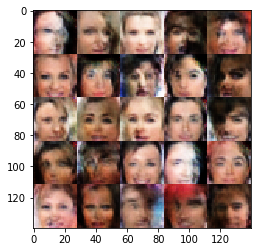

Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.8605
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.5991
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.7416


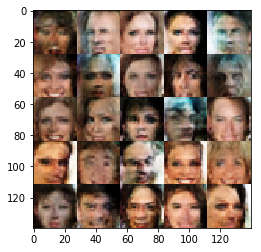

Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.5373
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.7751


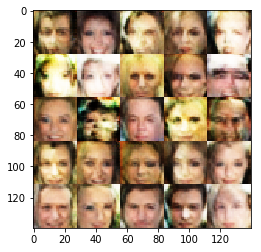

Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.5712
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.8725
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.5996
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.7367


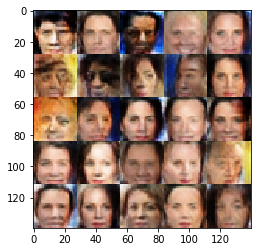

Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.6558


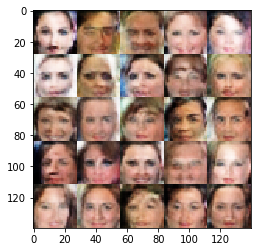

Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.5721
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.9981
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.6161
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.6958


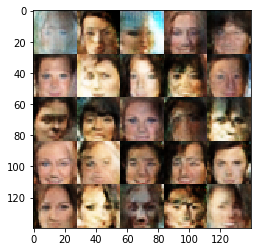

Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.8998


In [13]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.